# Calibration Postprocessing

## Kalibr (D455 to Body IMU)

In [35]:
from Go2Py.calibration import *
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

In [11]:
ext_params = [KalibrExtractExtrinsics(f'datasets/calibration/calibration/kalibr/dynamic/all/seq{i+1}.yaml') for i in range(5)]
int_params = KalibrExtractIntrinsics(f'datasets/calibration/calibration/kalibr/dynamic/all/seq{1}.yaml')

In [12]:
def computeSE3Mean(poses):
    T0 = poses[0]
    log_delta_Ts = []
    for T in poses:
        log_delta_Ts.append(pin.log6(np.linalg.inv(T0)@T).vector)
    log_delta_Ts = np.vstack(log_delta_Ts)
    return T0@pin.exp6(np.mean(log_delta_Ts, axis=0)).homogeneous


ext_result = {}
int_result = {}
camera_name_map = {'cam0':'infra1',
                   'cam1':'infra2',
                   'cam2':'color'}
for cam in ['cam0', 'cam1', 'cam2']:
    poses = [r[f'{cam}_T_imu'] for r in ext_params]
    ext_result[f'{camera_name_map[cam]}_T_imu']=computeSE3Mean(poses)
    int_result[camera_name_map[cam]]=int_params[cam]

In [13]:
int_result

{'infra1': {'camera_model': 'pinhole',
  'intrinsics': {'fu': 398.0379492735872,
   'fv': 401.10555839769535,
   'pu': 327.56389668833106,
   'pv': 244.66328819850395},
  'distortion_model': 'radtan',
  'distortion_coeffs': {'k1': 0.022437463738179255,
   'k2': -0.006800545399861931,
   'r1': 0.0007861230173005672,
   'r2': 0.0031405110415967147},
  'resolution': [640, 480]},
 'infra2': {'camera_model': 'pinhole',
  'intrinsics': {'fu': 398.170676888213,
   'fv': 401.14236478722404,
   'pu': 324.30936661646456,
   'pv': 244.30665138733275},
  'distortion_model': 'radtan',
  'distortion_coeffs': {'k1': 0.021509683195673927,
   'k2': -0.005685185848086602,
   'r1': 0.0005912786969070088,
   'r2': 0.0015930212849673176},
  'resolution': [640, 480]},
 'color': {'camera_model': 'pinhole',
  'intrinsics': {'fu': 389.87107372397037,
   'fv': 392.45741669539916,
   'pu': 323.75335233916996,
   'pv': 244.24311882848974},
  'distortion_model': 'radtan',
  'distortion_coeffs': {'k1': -0.031338536

In [14]:
ext_result

{'infra1_T_imu': array([[-0.046, -0.999, 0.017, 0.054],
        [-0.092, -0.013, -0.996, 0.067],
        [0.995, -0.047, -0.092, -0.343],
        [0.000, 0.000, 0.000, 1.000]]),
 'infra2_T_imu': array([[-0.040, -0.999, 0.017, -0.043],
        [-0.091, -0.013, -0.996, 0.066],
        [0.995, -0.041, -0.091, -0.344],
        [0.000, 0.000, 0.000, 1.000]]),
 'color_T_imu': array([[-0.039, -0.999, 0.014, -0.007],
        [-0.091, -0.010, -0.996, 0.066],
        [0.995, -0.040, -0.090, -0.344],
        [0.000, 0.000, 0.000, 1.000]])}

## Vicon2Gt

In [15]:
imu_T_marker = Vicon2GtExtractParams('datasets/calibration/calibration/vicon2gt/seq1/seq1_vicon2gt_info.txt')
imu_T_marker

array([[-0.887, 0.452, 0.097, 0.051],
       [-0.454, -0.891, -0.002, 0.006],
       [0.086, -0.046, 0.995, 0.017],
       [0.000, 0.000, 0.000, 1.000]])

## Kinematics-Vicon

In [16]:
import pickle
with open('datasets/calibration/calibration/kinematic-vicon-dataset/inplace_rotation.pkl', 'rb') as f:
    data = pickle.load(f)

In [17]:
from Go2Py.sim.mujoco import Go2Sim
robot = Go2Sim(dt=0.001)

In [18]:
import time
import numpy as np
mjworld_Ts_base = []
vworld_Ts_marker = []
Kp = 200
Kv = 5.0
robot.standUpReset()
for i in range(len(data['q'])):
    state = robot.getJointStates()
    tau = Kp*np.eye(12)@(data['q'][i] - state['q']).reshape(12,1)+data['tau'][i].reshape(12,1) + \
          Kv*np.eye(12)@(data['dq'][i] - state['dq']).reshape(12,1)
    robot.setCommands(np.zeros(12), np.zeros(12), np.zeros(12), np.zeros(12), tau)

    t, q = robot.getPose()
    R = pin.Quaternion(np.hstack([q[1:], q[0]])).matrix()
    mjworld_T_base=np.vstack([np.hstack([R, t.reshape(3,1)]), np.array([0,0,0,1])])
    vworld_T_marker = data['world_T_marker'][i]
    mjworld_Ts_base.append(mjworld_T_base.reshape(1,4,4))
    vworld_Ts_marker.append(vworld_T_marker.reshape(1,4,4))
    robot.step()


In [20]:
mjworld_Ts_base = np.vstack(mjworld_Ts_base[:-3000])
vworld_Ts_marker = np.vstack(vworld_Ts_marker[:-3000])

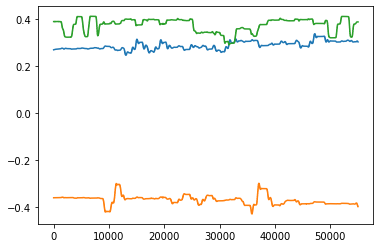

In [21]:
import matplotlib.pyplot as plt
plt.plot(vworld_Ts_marker[:,0:3,-1])

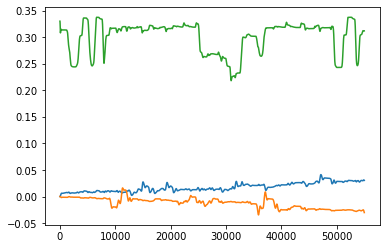

In [22]:
plt.plot(mjworld_Ts_base[:,0:3,-1])

In [23]:
from SimpleHandEye.solvers import OpenCVSolver

In [24]:
solver = OpenCVSolver()

In [25]:
A = mjworld_Ts_base
B = vworld_Ts_marker
X , Y = solver.solve(A = A, B = B)

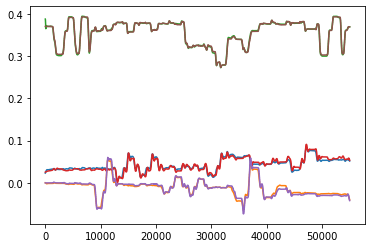

In [26]:
t1 = np.array([A[i]@X for i in range(A.shape[0])])[:,0:3,-1]
t2 = np.array([Y@B[i] for i in range(B.shape[0])])[:,0:3,-1]
plt.plot(t1)
plt.plot(t2)

In [27]:
base_T_marker = X
base_T_marker


array([[-0.888, 0.453, 0.076, 0.023],
       [-0.454, -0.891, -0.004, -0.000],
       [0.066, -0.038, 0.997, 0.058],
       [0.000, 0.000, 0.000, 1.000]])

# Load Lidar to Camera extrinsics

In [40]:
import json
with open('datasets/calibration/calibration/utlidar-camera/calib.json', 'r') as f:  
    ext = json.load(f)
lidar_T_camera = ext['results']['init_T_lidar_camera']
t = np.array(lidar_T_camera[0:3])
q = np.array(lidar_T_camera[3:])
R = pin.Quaternion(q).matrix()
lidar_T_camera=np.vstack([np.hstack([R, t.reshape(3,1)]), np.array([0,0,0,1])])
lidar_T_camera

array([[0.124, 0.311, -0.942, -0.140],
       [-0.992, 0.014, -0.125, -0.037],
       [-0.026, 0.950, 0.310, -0.041],
       [0.000, 0.000, 0.000, 1.000]])

# Combine it All

In [41]:
ext_result['base_T_marker'] = base_T_marker
ext_result['imu_T_marker'] = imu_T_marker
ext_result['lidar_T_color'] = lidar_T_camera
ext_result

{'infra1_T_imu': array([[-0.046, -0.999, 0.017, 0.054],
        [-0.092, -0.013, -0.996, 0.067],
        [0.995, -0.047, -0.092, -0.343],
        [0.000, 0.000, 0.000, 1.000]]),
 'infra2_T_imu': array([[-0.040, -0.999, 0.017, -0.043],
        [-0.091, -0.013, -0.996, 0.066],
        [0.995, -0.041, -0.091, -0.344],
        [0.000, 0.000, 0.000, 1.000]]),
 'color_T_imu': array([[-0.039, -0.999, 0.014, -0.007],
        [-0.091, -0.010, -0.996, 0.066],
        [0.995, -0.040, -0.090, -0.344],
        [0.000, 0.000, 0.000, 1.000]]),
 'base_T_marker': array([[-0.888, 0.453, 0.076, 0.023],
        [-0.454, -0.891, -0.004, -0.000],
        [0.066, -0.038, 0.997, 0.058],
        [0.000, 0.000, 0.000, 1.000]]),
 'imu_T_marker': array([[-0.887, 0.452, 0.097, 0.051],
        [-0.454, -0.891, -0.002, 0.006],
        [0.086, -0.046, 0.995, 0.017],
        [0.000, 0.000, 0.000, 1.000]]),
 'lidar_T_color': array([[0.124, 0.311, -0.942, -0.140],
        [-0.992, 0.014, -0.125, -0.037],
        [-0.026

In [42]:
from Go2Py.calibration import ExtrinsicCalibrationManager
manager = ExtrinsicCalibrationManager()

In [43]:
for key, T in zip(ext_result.keys(), ext_result.values()):
    parent = key.split('_T_')[0]
    child = key.split('_T_')[1]
    manager.add(parent=parent, child=child, R=T[0:3,0:3], t=T[0:3,-1])

In [44]:
ext_wrt_base = manager.get_all('base')
ext_wrt_imu = manager.get_all('imu')
result = {'ext_wrt_base':ext_wrt_base,
          'ext_wrt_imu':ext_wrt_base}

In [37]:
with open('datasets/calibration/final_results.pkl', 'wb') as f:
    pickle.dump(result, f)

In [19]:
import pickle
with open('datasets/calibration/final_results.pkl', 'rb') as f:
    result = pickle.load(f)

In [20]:
result['ext_wrt_base']

{'infra1_wrt_base': array([[-0.04633745, -0.07139989,  0.99637086,  0.32161791],
        [-0.99882303, -0.01099835, -0.04723963,  0.03330488],
        [ 0.01433134, -0.99738713, -0.07080622,  0.08162181],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'imu_wrt_base': array([[ 9.99781597e-01, -2.84572838e-05, -2.08987443e-02,
         -2.73533177e-02],
        [-7.00270663e-06,  9.99998561e-01, -1.69667706e-03,
         -5.49944525e-03],
        [ 2.08987625e-02,  1.69645285e-03,  9.99780158e-01,
          3.99126757e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'infra2_wrt_base': array([[-0.04036617, -0.07029462,  0.9967092 ,  0.31796855],
        [-0.99908557, -0.01122962, -0.0412544 , -0.06191919],
        [ 0.01409262, -0.99746306, -0.06977704,  0.08277337],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'color_wrt_base': array([[-0.03955514, -0.07002279,  0.99676085,  0.31941529],
        [-0.9991

In [21]:
result['ext_wrt_imu']

{'infra1_wrt_base': array([[-0.04633745, -0.07139989,  0.99637086,  0.32161791],
        [-0.99882303, -0.01099835, -0.04723963,  0.03330488],
        [ 0.01433134, -0.99738713, -0.07080622,  0.08162181],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'imu_wrt_base': array([[ 9.99781597e-01, -2.84572838e-05, -2.08987443e-02,
         -2.73533177e-02],
        [-7.00270663e-06,  9.99998561e-01, -1.69667706e-03,
         -5.49944525e-03],
        [ 2.08987625e-02,  1.69645285e-03,  9.99780158e-01,
          3.99126757e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'infra2_wrt_base': array([[-0.04036617, -0.07029462,  0.9967092 ,  0.31796855],
        [-0.99908557, -0.01122962, -0.0412544 , -0.06191919],
        [ 0.01409262, -0.99746306, -0.06977704,  0.08277337],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'color_wrt_base': array([[-0.03955514, -0.07002279,  0.99676085,  0.31941529],
        [-0.9991

In [22]:
import pinocchio as pin
T = result['ext_wrt_imu']['color_wrt_base']
from scipy.spatial.transform import Rotation 
T[0:3,-1], Rotation.from_matrix(T[0:3,0:3]).as_euler(seq='xyz')

(array([ 0.31941529, -0.02578968,  0.08231088]),
 array([-1.64049103, -0.01112486, -1.61036424]))

## 3D Visualizations

In [23]:
import rerun as rr
rr.init('ext_visualization')
rr.spawn()

[2024-05-28T02:56:54Z WARN  re_sdk_comms::tcp_client] Tried to flush while TCP stream was still Pending. Data was possibly dropped.
[2024-05-28T02:56:54Z INFO  re_sdk_comms::server] Hosting a SDK server over TCP at 0.0.0.0:9876. Connect with the Rerun logging SDK.
[2024-05-28T02:56:54Z INFO  winit::platform_impl::platform::x11::window] Guessed window scale factor: 1
[2024-05-28T02:56:54Z INFO  re_sdk_comms::server] New SDK client connected: 127.0.0.1:37256
[2024-05-28T02:56:54Z INFO  re_sdk_comms::server] New SDK client connected: 127.0.0.1:37250


[2024-05-28T02:56:54Z WARN  wgpu_hal::vulkan::instance] Unable to find extension: VK_EXT_swapchain_colorspace
MESA-INTEL: warning: Performance support disabled, consider sysctl dev.i915.perf_stream_paranoid=0

[2024-05-28T02:56:54Z INFO  egui_wgpu] There were 3 available wgpu adapters: {backend: Vulkan, device_type: DiscreteGpu, name: "NVIDIA GeForce GTX 1050", driver: "NVIDIA", driver_info: "535.171.04", vendor: 0x10DE, device: 0x1C8D}, {backend: Vulkan, device_type: IntegratedGpu, name: "Intel(R) HD Graphics 630 (KBL GT2)", driver: "Intel open-source Mesa driver", driver_info: "Mesa 21.2.6", vendor: 0x8086, device: 0x591B}, {backend: Vulkan, device_type: Cpu, name: "llvmpipe (LLVM 12.0.0, 256 bits)", driver: "llvmpipe", driver_info: "Mesa 21.2.6 (LLVM 12.0.0)", vendor: 0x10005}


In [24]:
rr.log("world/base", rr.Transform3D(translation=[0,0,0], rotation=rr.Quaternion(xyzw=[0,0,0,1])))

In [25]:
t=[0.28945, 0, -0.046825]
R = Rotation.from_euler(seq='xyz', angles=[0, 2.8782, 0])
q = R.as_quat()
rr.log("world/base/lidar", rr.Transform3D(translation=t, rotation=rr.Quaternion(xyzw=q)))

In [35]:
import numpy as np
result['ext_wrt_base']['lidar_wrt_base']=np.vstack([np.hstack([R.as_matrix(), np.array(t).reshape(3,1)]), np.array([0,0,0,1])])

In [27]:
import pinocchio as pin
for key, T in result['ext_wrt_base'].items():
    child, parent = key.split('_wrt_')
    print(parent, child)
    qq = pin.Quaternion(T[0:3,0:3])
    rr.log(f"{parent}/{child}", rr.Transform3D(translation=T[0:3,-1].tolist(), rotation=rr.Quaternion(xyzw=[qq.x,qq.y,qq.z, qq.w])))

base infra1
base imu
base infra2
base color
base marker
base lidar
